In [1]:
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model

import math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sys, os

%matplotlib inline

/home/fountainhead_gq/anaconda3/envs/tensorflow_p35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


###  generator

In [2]:
def build_generator(inputs, image_size):
    """Build a Generator Model
    Stacks of BN-ReLU-Conv2DTranpose to generate fake images
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.
    # Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size: Target size of one side (assuming square image)
    # Returns
        Model: Generator Model
    """
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    return generator

###  discriminator

In [3]:
def build_discriminator(inputs):
    """Build a Discriminator Model
    Stacks of LeakyReLU-Conv2D to discriminate real from fake
    The network does not converge with BN so it is not used here
    unlike in [1]
    # Arguments
        inputs (Layer): Input layer of the discriminator (the image)
    # Returns
        Model: Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator

### build model

In [5]:
def build_and_train_models(lr=0.0002, decay=6e-8, image_size=28):

    model_name = "dcgan_mnist"
    # The latent or z vector is 100-dim
    latent_size = 100
    input_shape = (image_size, image_size, 1)

    # Build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    
    # [1] uses Adam, but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # Build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

    # Build adversarial model = generator + discriminator
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    discriminator.trainable = False
    adversarial = Model(inputs, 
                        discriminator(generator(inputs)),
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # Train Discriminator and Adversarial Networks
    models = (generator, discriminator, adversarial)
    params = (latent_size, model_name)
    return models, params


### train

In [6]:
def train(models, params, train_steps=5000, batch_size=128, save_interval=500):
    """Train the Discriminator and Adversarial Networks
    Alternately train Discriminator and Adversarial networks by batch
    Discriminator is trained first with properly real and fake images
    Adversarial is trained next with fake images pretending to be real
    Generate sample images per save_interval
    # Arguments
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters
    """
    # MNIST dataset
    (x_train, _), (_, _) = mnist.load_data()

    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255
    
    generator, discriminator, adversarial = models
    latent_size, model_name = params

    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    for i in range(train_steps):
        # Random real images
        rand_indexes = np.random.randint(0, x_train.shape[0], size=batch_size)
        real_images = x_train[rand_indexes]
        
        # Generate fake images
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_images = generator.predict(noise)
        x = np.concatenate((real_images, fake_images))
        # Label real and fake images
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0
        
        # Train the Discriminator network
        metrics = discriminator.train_on_batch(x, y)
        loss = metrics[0]
        acc = metrics[1]
        log = "step: %d, [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # Generate random noise
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # Label fake images as real
        y = np.ones([batch_size, 1])
        # Train the Adversarial network
        metrics = adversarial.train_on_batch(noise, y)
        loss = metrics[0]
        acc = metrics[1]
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False
            plot_images(generator,
                        noise_input=noise_input,
                        show=show,
                        step=(i + 1),
                        model_name=model_name)
    
    generator.save(model_name + ".h5")


### save image

In [7]:
def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    # Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')
    

In [8]:
# models, params = build_and_train_models(lr=0.0002, decay=6e-8, image_size=28)
models, params = build_and_train_models()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         204928    
__________

/home/fountainhead_gq/anaconda3/envs/tensorflow_p35/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [discriminator loss: 0.690537, acc: 0.800781] [adversarial loss: 1.053278, acc: 0.000000]
1: [discriminator loss: 0.572476, acc: 0.742188] [adversarial loss: 1.261385, acc: 0.000000]
2: [discriminator loss: 0.424014, acc: 0.964844] [adversarial loss: 1.159014, acc: 0.000000]
3: [discriminator loss: 0.269174, acc: 1.000000] [adversarial loss: 1.696421, acc: 0.000000]
4: [discriminator loss: 0.170867, acc: 0.988281] [adversarial loss: 0.327070, acc: 1.000000]
5: [discriminator loss: 0.373803, acc: 0.500000] [adversarial loss: 2.369308, acc: 0.000000]
6: [discriminator loss: 0.174100, acc: 0.964844] [adversarial loss: 1.485086, acc: 0.000000]
7: [discriminator loss: 0.090417, acc: 0.992188] [adversarial loss: 1.145192, acc: 0.000000]
8: [discriminator loss: 0.056280, acc: 1.000000] [adversarial loss: 0.915798, acc: 0.000000]
9: [discriminator loss: 0.050632, acc: 1.000000] [adversarial loss: 0.690995, acc: 0.507812]
10: [discriminator loss: 0.045767, acc: 1.000000] [adversarial loss: 0

88: [discriminator loss: 0.000064, acc: 1.000000] [adversarial loss: 0.000298, acc: 1.000000]
89: [discriminator loss: 0.000083, acc: 1.000000] [adversarial loss: 0.000176, acc: 1.000000]
90: [discriminator loss: 0.000056, acc: 1.000000] [adversarial loss: 0.000207, acc: 1.000000]
91: [discriminator loss: 0.000071, acc: 1.000000] [adversarial loss: 0.000100, acc: 1.000000]
92: [discriminator loss: 0.000127, acc: 1.000000] [adversarial loss: 0.000007, acc: 1.000000]
93: [discriminator loss: 0.000088, acc: 1.000000] [adversarial loss: 0.000141, acc: 1.000000]
94: [discriminator loss: 0.000061, acc: 1.000000] [adversarial loss: 0.000058, acc: 1.000000]
95: [discriminator loss: 0.000049, acc: 1.000000] [adversarial loss: 0.000088, acc: 1.000000]
96: [discriminator loss: 0.000071, acc: 1.000000] [adversarial loss: 0.000022, acc: 1.000000]
97: [discriminator loss: 0.000047, acc: 1.000000] [adversarial loss: 0.000069, acc: 1.000000]
98: [discriminator loss: 0.000053, acc: 1.000000] [adversari

176: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
177: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
178: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
179: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
180: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
181: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
182: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
183: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
184: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
185: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
186: [discriminator loss: 0.000000, acc: 1.000000]

264: [discriminator loss: 0.000001, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
265: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
266: [discriminator loss: 0.000001, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
267: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
268: [discriminator loss: 0.000001, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
269: [discriminator loss: 0.000001, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
270: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
271: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
272: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
273: [discriminator loss: 0.000000, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
274: [discriminator loss: 0.000003, acc: 1.000000]

352: [discriminator loss: 0.000140, acc: 1.000000] [adversarial loss: 0.000283, acc: 1.000000]
353: [discriminator loss: 0.000063, acc: 1.000000] [adversarial loss: 0.000236, acc: 1.000000]
354: [discriminator loss: 0.000257, acc: 1.000000] [adversarial loss: 0.000274, acc: 1.000000]
355: [discriminator loss: 0.000329, acc: 1.000000] [adversarial loss: 0.000223, acc: 1.000000]
356: [discriminator loss: 0.000159, acc: 1.000000] [adversarial loss: 0.000201, acc: 1.000000]
357: [discriminator loss: 0.000307, acc: 1.000000] [adversarial loss: 0.000286, acc: 1.000000]
358: [discriminator loss: 0.000235, acc: 1.000000] [adversarial loss: 0.000312, acc: 1.000000]
359: [discriminator loss: 0.000167, acc: 1.000000] [adversarial loss: 0.000281, acc: 1.000000]
360: [discriminator loss: 0.000343, acc: 1.000000] [adversarial loss: 0.000287, acc: 1.000000]
361: [discriminator loss: 0.000408, acc: 1.000000] [adversarial loss: 0.000386, acc: 1.000000]
362: [discriminator loss: 0.000690, acc: 1.000000]

440: [discriminator loss: 0.113063, acc: 0.992188] [adversarial loss: 1.374285, acc: 0.000000]
441: [discriminator loss: 0.154893, acc: 0.976562] [adversarial loss: 1.325630, acc: 0.000000]
442: [discriminator loss: 0.163894, acc: 0.964844] [adversarial loss: 1.188464, acc: 0.000000]
443: [discriminator loss: 0.167388, acc: 0.984375] [adversarial loss: 1.373049, acc: 0.000000]
444: [discriminator loss: 0.182314, acc: 0.968750] [adversarial loss: 1.434075, acc: 0.000000]
445: [discriminator loss: 0.192173, acc: 0.968750] [adversarial loss: 1.521627, acc: 0.000000]
446: [discriminator loss: 0.218139, acc: 0.960938] [adversarial loss: 1.995875, acc: 0.000000]
447: [discriminator loss: 0.248117, acc: 0.960938] [adversarial loss: 1.452851, acc: 0.000000]
448: [discriminator loss: 0.292368, acc: 0.980469] [adversarial loss: 4.941463, acc: 0.000000]
449: [discriminator loss: 0.867163, acc: 0.679688] [adversarial loss: 0.001570, acc: 1.000000]
450: [discriminator loss: 2.438115, acc: 0.500000]

528: [discriminator loss: 0.184630, acc: 0.941406] [adversarial loss: 0.133423, acc: 1.000000]
529: [discriminator loss: 0.101453, acc: 0.984375] [adversarial loss: 0.417328, acc: 0.929688]
530: [discriminator loss: 0.126995, acc: 0.968750] [adversarial loss: 0.615501, acc: 0.679688]
531: [discriminator loss: 0.120873, acc: 0.984375] [adversarial loss: 0.380174, acc: 0.953125]
532: [discriminator loss: 0.125429, acc: 0.976562] [adversarial loss: 1.230266, acc: 0.054688]
533: [discriminator loss: 0.151380, acc: 0.949219] [adversarial loss: 0.011938, acc: 1.000000]
534: [discriminator loss: 0.264314, acc: 0.890625] [adversarial loss: 2.404663, acc: 0.031250]
535: [discriminator loss: 0.307096, acc: 0.835938] [adversarial loss: 0.000741, acc: 1.000000]
536: [discriminator loss: 0.323668, acc: 0.835938] [adversarial loss: 0.152989, acc: 1.000000]
537: [discriminator loss: 0.113184, acc: 0.984375] [adversarial loss: 0.503174, acc: 0.726562]
538: [discriminator loss: 0.139637, acc: 0.968750]

616: [discriminator loss: 0.603373, acc: 0.691406] [adversarial loss: 0.020144, acc: 1.000000]
617: [discriminator loss: 0.584307, acc: 0.691406] [adversarial loss: 1.234894, acc: 0.171875]
618: [discriminator loss: 0.519981, acc: 0.734375] [adversarial loss: 0.090281, acc: 1.000000]
619: [discriminator loss: 0.584800, acc: 0.640625] [adversarial loss: 2.493156, acc: 0.000000]
620: [discriminator loss: 0.631249, acc: 0.667969] [adversarial loss: 0.072204, acc: 1.000000]
621: [discriminator loss: 0.357608, acc: 0.828125] [adversarial loss: 0.616688, acc: 0.640625]
622: [discriminator loss: 0.382339, acc: 0.847656] [adversarial loss: 0.661030, acc: 0.593750]
623: [discriminator loss: 0.323873, acc: 0.882812] [adversarial loss: 0.967069, acc: 0.289062]
624: [discriminator loss: 0.260176, acc: 0.937500] [adversarial loss: 1.076586, acc: 0.203125]
625: [discriminator loss: 0.255862, acc: 0.933594] [adversarial loss: 0.500260, acc: 0.757812]
626: [discriminator loss: 0.241691, acc: 0.917969]

704: [discriminator loss: 0.533592, acc: 0.683594] [adversarial loss: 0.081263, acc: 1.000000]
705: [discriminator loss: 0.686542, acc: 0.601562] [adversarial loss: 1.516590, acc: 0.039062]
706: [discriminator loss: 0.600263, acc: 0.671875] [adversarial loss: 0.305394, acc: 0.960938]
707: [discriminator loss: 0.704552, acc: 0.578125] [adversarial loss: 2.422503, acc: 0.000000]
708: [discriminator loss: 0.703940, acc: 0.589844] [adversarial loss: 0.355736, acc: 0.914062]
709: [discriminator loss: 0.311859, acc: 0.902344] [adversarial loss: 0.468101, acc: 0.843750]
710: [discriminator loss: 0.310017, acc: 0.906250] [adversarial loss: 0.474926, acc: 0.843750]
711: [discriminator loss: 0.371564, acc: 0.859375] [adversarial loss: 0.550985, acc: 0.734375]
712: [discriminator loss: 0.374742, acc: 0.882812] [adversarial loss: 0.436960, acc: 0.859375]
713: [discriminator loss: 0.357608, acc: 0.875000] [adversarial loss: 0.541279, acc: 0.757812]
714: [discriminator loss: 0.346434, acc: 0.890625]

792: [discriminator loss: 0.593208, acc: 0.710938] [adversarial loss: 0.752793, acc: 0.468750]
793: [discriminator loss: 0.618267, acc: 0.644531] [adversarial loss: 0.839606, acc: 0.320312]
794: [discriminator loss: 0.539161, acc: 0.746094] [adversarial loss: 0.535015, acc: 0.781250]
795: [discriminator loss: 0.578190, acc: 0.679688] [adversarial loss: 0.941123, acc: 0.289062]
796: [discriminator loss: 0.591483, acc: 0.671875] [adversarial loss: 0.584450, acc: 0.765625]
797: [discriminator loss: 0.539784, acc: 0.765625] [adversarial loss: 1.068291, acc: 0.101562]
798: [discriminator loss: 0.552915, acc: 0.726562] [adversarial loss: 0.353996, acc: 0.937500]
799: [discriminator loss: 0.729984, acc: 0.531250] [adversarial loss: 1.741320, acc: 0.000000]
800: [discriminator loss: 0.763642, acc: 0.535156] [adversarial loss: 0.540706, acc: 0.773438]
801: [discriminator loss: 0.656359, acc: 0.554688] [adversarial loss: 1.494267, acc: 0.015625]
802: [discriminator loss: 0.579184, acc: 0.671875]

880: [discriminator loss: 0.670987, acc: 0.562500] [adversarial loss: 0.610420, acc: 0.656250]
881: [discriminator loss: 0.652425, acc: 0.554688] [adversarial loss: 1.448392, acc: 0.000000]
882: [discriminator loss: 0.623973, acc: 0.609375] [adversarial loss: 0.599645, acc: 0.695312]
883: [discriminator loss: 0.628677, acc: 0.574219] [adversarial loss: 1.101221, acc: 0.085938]
884: [discriminator loss: 0.609453, acc: 0.683594] [adversarial loss: 0.730681, acc: 0.429688]
885: [discriminator loss: 0.589747, acc: 0.695312] [adversarial loss: 0.894930, acc: 0.218750]
886: [discriminator loss: 0.542402, acc: 0.742188] [adversarial loss: 0.602324, acc: 0.710938]
887: [discriminator loss: 0.595925, acc: 0.687500] [adversarial loss: 0.858302, acc: 0.320312]
888: [discriminator loss: 0.596285, acc: 0.687500] [adversarial loss: 0.822417, acc: 0.398438]
889: [discriminator loss: 0.590460, acc: 0.722656] [adversarial loss: 0.961481, acc: 0.156250]
890: [discriminator loss: 0.544760, acc: 0.734375]

968: [discriminator loss: 0.551524, acc: 0.699219] [adversarial loss: 0.734719, acc: 0.460938]
969: [discriminator loss: 0.574911, acc: 0.699219] [adversarial loss: 1.311136, acc: 0.015625]
970: [discriminator loss: 0.530253, acc: 0.757812] [adversarial loss: 0.827749, acc: 0.328125]
971: [discriminator loss: 0.560486, acc: 0.730469] [adversarial loss: 1.218019, acc: 0.125000]
972: [discriminator loss: 0.542977, acc: 0.710938] [adversarial loss: 0.730171, acc: 0.476562]
973: [discriminator loss: 0.508401, acc: 0.789062] [adversarial loss: 1.170046, acc: 0.109375]
974: [discriminator loss: 0.569829, acc: 0.679688] [adversarial loss: 0.557800, acc: 0.812500]
975: [discriminator loss: 0.595937, acc: 0.625000] [adversarial loss: 1.582497, acc: 0.015625]
976: [discriminator loss: 0.560452, acc: 0.679688] [adversarial loss: 0.738438, acc: 0.476562]
977: [discriminator loss: 0.567785, acc: 0.691406] [adversarial loss: 1.235397, acc: 0.085938]
978: [discriminator loss: 0.529365, acc: 0.734375]

1054: [discriminator loss: 0.497774, acc: 0.804688] [adversarial loss: 1.497722, acc: 0.039062]
1055: [discriminator loss: 0.527311, acc: 0.722656] [adversarial loss: 0.671434, acc: 0.640625]
1056: [discriminator loss: 0.587260, acc: 0.652344] [adversarial loss: 1.791292, acc: 0.062500]
1057: [discriminator loss: 0.585549, acc: 0.660156] [adversarial loss: 0.758507, acc: 0.453125]
1058: [discriminator loss: 0.526552, acc: 0.667969] [adversarial loss: 1.583568, acc: 0.039062]
1059: [discriminator loss: 0.541900, acc: 0.703125] [adversarial loss: 0.936632, acc: 0.281250]
1060: [discriminator loss: 0.487745, acc: 0.769531] [adversarial loss: 1.330533, acc: 0.078125]
1061: [discriminator loss: 0.470789, acc: 0.765625] [adversarial loss: 1.136515, acc: 0.148438]
1062: [discriminator loss: 0.440957, acc: 0.871094] [adversarial loss: 1.247918, acc: 0.093750]
1063: [discriminator loss: 0.470364, acc: 0.820312] [adversarial loss: 1.210659, acc: 0.140625]
1064: [discriminator loss: 0.449173, acc

1140: [discriminator loss: 0.560608, acc: 0.726562] [adversarial loss: 0.715716, acc: 0.531250]
1141: [discriminator loss: 0.586757, acc: 0.683594] [adversarial loss: 1.983268, acc: 0.007812]
1142: [discriminator loss: 0.518522, acc: 0.718750] [adversarial loss: 1.029153, acc: 0.328125]
1143: [discriminator loss: 0.493043, acc: 0.792969] [adversarial loss: 1.469594, acc: 0.062500]
1144: [discriminator loss: 0.481928, acc: 0.769531] [adversarial loss: 0.934509, acc: 0.343750]
1145: [discriminator loss: 0.455808, acc: 0.800781] [adversarial loss: 1.206986, acc: 0.171875]
1146: [discriminator loss: 0.475206, acc: 0.773438] [adversarial loss: 1.036778, acc: 0.304688]
1147: [discriminator loss: 0.496740, acc: 0.753906] [adversarial loss: 1.382589, acc: 0.062500]
1148: [discriminator loss: 0.472099, acc: 0.800781] [adversarial loss: 0.959409, acc: 0.367188]
1149: [discriminator loss: 0.478769, acc: 0.738281] [adversarial loss: 1.590494, acc: 0.031250]
1150: [discriminator loss: 0.480285, acc

1226: [discriminator loss: 0.507373, acc: 0.730469] [adversarial loss: 0.863602, acc: 0.437500]
1227: [discriminator loss: 0.507577, acc: 0.746094] [adversarial loss: 1.390217, acc: 0.085938]
1228: [discriminator loss: 0.548219, acc: 0.738281] [adversarial loss: 0.774672, acc: 0.507812]
1229: [discriminator loss: 0.551406, acc: 0.691406] [adversarial loss: 1.444566, acc: 0.031250]
1230: [discriminator loss: 0.539802, acc: 0.710938] [adversarial loss: 0.895946, acc: 0.359375]
1231: [discriminator loss: 0.494428, acc: 0.734375] [adversarial loss: 1.292063, acc: 0.132812]
1232: [discriminator loss: 0.470103, acc: 0.792969] [adversarial loss: 1.028412, acc: 0.257812]
1233: [discriminator loss: 0.469935, acc: 0.800781] [adversarial loss: 1.270698, acc: 0.156250]
1234: [discriminator loss: 0.537166, acc: 0.722656] [adversarial loss: 0.905235, acc: 0.375000]
1235: [discriminator loss: 0.533405, acc: 0.734375] [adversarial loss: 1.654894, acc: 0.078125]
1236: [discriminator loss: 0.567393, acc

1312: [discriminator loss: 0.514037, acc: 0.726562] [adversarial loss: 1.498757, acc: 0.070312]
1313: [discriminator loss: 0.562226, acc: 0.726562] [adversarial loss: 0.785778, acc: 0.429688]
1314: [discriminator loss: 0.555603, acc: 0.695312] [adversarial loss: 1.703402, acc: 0.031250]
1315: [discriminator loss: 0.567281, acc: 0.707031] [adversarial loss: 0.783024, acc: 0.492188]
1316: [discriminator loss: 0.636681, acc: 0.625000] [adversarial loss: 1.813960, acc: 0.007812]
1317: [discriminator loss: 0.593812, acc: 0.671875] [adversarial loss: 0.743337, acc: 0.554688]
1318: [discriminator loss: 0.535099, acc: 0.703125] [adversarial loss: 1.450050, acc: 0.078125]
1319: [discriminator loss: 0.522040, acc: 0.734375] [adversarial loss: 0.796151, acc: 0.437500]
1320: [discriminator loss: 0.597187, acc: 0.679688] [adversarial loss: 1.534880, acc: 0.085938]
1321: [discriminator loss: 0.559957, acc: 0.718750] [adversarial loss: 0.747468, acc: 0.546875]
1322: [discriminator loss: 0.584111, acc

1398: [discriminator loss: 0.560503, acc: 0.695312] [adversarial loss: 1.842940, acc: 0.054688]
1399: [discriminator loss: 0.627534, acc: 0.636719] [adversarial loss: 0.826259, acc: 0.476562]
1400: [discriminator loss: 0.648782, acc: 0.625000] [adversarial loss: 1.673706, acc: 0.070312]
1401: [discriminator loss: 0.595328, acc: 0.679688] [adversarial loss: 0.865825, acc: 0.445312]
1402: [discriminator loss: 0.546272, acc: 0.730469] [adversarial loss: 1.370222, acc: 0.148438]
1403: [discriminator loss: 0.573698, acc: 0.718750] [adversarial loss: 0.896513, acc: 0.414062]
1404: [discriminator loss: 0.562285, acc: 0.691406] [adversarial loss: 1.526933, acc: 0.070312]
1405: [discriminator loss: 0.491498, acc: 0.777344] [adversarial loss: 1.050557, acc: 0.265625]
1406: [discriminator loss: 0.504724, acc: 0.761719] [adversarial loss: 1.511377, acc: 0.062500]
1407: [discriminator loss: 0.520751, acc: 0.707031] [adversarial loss: 0.783260, acc: 0.429688]
1408: [discriminator loss: 0.520596, acc

1484: [discriminator loss: 0.485476, acc: 0.785156] [adversarial loss: 1.096972, acc: 0.265625]
1485: [discriminator loss: 0.494760, acc: 0.800781] [adversarial loss: 1.320695, acc: 0.179688]
1486: [discriminator loss: 0.498078, acc: 0.792969] [adversarial loss: 1.018735, acc: 0.289062]
1487: [discriminator loss: 0.528886, acc: 0.757812] [adversarial loss: 1.382852, acc: 0.109375]
1488: [discriminator loss: 0.463878, acc: 0.800781] [adversarial loss: 0.920058, acc: 0.351562]
1489: [discriminator loss: 0.523380, acc: 0.746094] [adversarial loss: 1.748552, acc: 0.039062]
1490: [discriminator loss: 0.572101, acc: 0.687500] [adversarial loss: 0.811015, acc: 0.453125]
1491: [discriminator loss: 0.528759, acc: 0.730469] [adversarial loss: 1.801878, acc: 0.054688]
1492: [discriminator loss: 0.587032, acc: 0.660156] [adversarial loss: 0.784559, acc: 0.484375]
1493: [discriminator loss: 0.587515, acc: 0.687500] [adversarial loss: 1.673315, acc: 0.046875]
1494: [discriminator loss: 0.522660, acc

1570: [discriminator loss: 0.478247, acc: 0.773438] [adversarial loss: 1.625984, acc: 0.046875]
1571: [discriminator loss: 0.494110, acc: 0.753906] [adversarial loss: 0.835083, acc: 0.453125]
1572: [discriminator loss: 0.578322, acc: 0.703125] [adversarial loss: 2.198166, acc: 0.015625]
1573: [discriminator loss: 0.603917, acc: 0.652344] [adversarial loss: 0.571747, acc: 0.664062]
1574: [discriminator loss: 0.632118, acc: 0.617188] [adversarial loss: 2.055298, acc: 0.015625]
1575: [discriminator loss: 0.575140, acc: 0.683594] [adversarial loss: 0.982867, acc: 0.343750]
1576: [discriminator loss: 0.538211, acc: 0.726562] [adversarial loss: 1.560153, acc: 0.093750]
1577: [discriminator loss: 0.524804, acc: 0.738281] [adversarial loss: 0.924639, acc: 0.343750]
1578: [discriminator loss: 0.532489, acc: 0.707031] [adversarial loss: 1.537354, acc: 0.070312]
1579: [discriminator loss: 0.500756, acc: 0.746094] [adversarial loss: 1.016552, acc: 0.335938]
1580: [discriminator loss: 0.514276, acc

1656: [discriminator loss: 0.490321, acc: 0.816406] [adversarial loss: 1.283280, acc: 0.148438]
1657: [discriminator loss: 0.511739, acc: 0.785156] [adversarial loss: 1.144993, acc: 0.203125]
1658: [discriminator loss: 0.515624, acc: 0.742188] [adversarial loss: 1.640251, acc: 0.140625]
1659: [discriminator loss: 0.534047, acc: 0.734375] [adversarial loss: 0.844707, acc: 0.406250]
1660: [discriminator loss: 0.567972, acc: 0.671875] [adversarial loss: 1.820858, acc: 0.078125]
1661: [discriminator loss: 0.581770, acc: 0.703125] [adversarial loss: 0.820842, acc: 0.453125]
1662: [discriminator loss: 0.567245, acc: 0.656250] [adversarial loss: 1.776466, acc: 0.054688]
1663: [discriminator loss: 0.564429, acc: 0.718750] [adversarial loss: 0.845798, acc: 0.500000]
1664: [discriminator loss: 0.508740, acc: 0.738281] [adversarial loss: 1.659415, acc: 0.070312]
1665: [discriminator loss: 0.510579, acc: 0.765625] [adversarial loss: 0.926246, acc: 0.351562]
1666: [discriminator loss: 0.513517, acc

1742: [discriminator loss: 0.516583, acc: 0.730469] [adversarial loss: 1.328740, acc: 0.164062]
1743: [discriminator loss: 0.502255, acc: 0.761719] [adversarial loss: 1.160524, acc: 0.257812]
1744: [discriminator loss: 0.502322, acc: 0.765625] [adversarial loss: 1.469314, acc: 0.171875]
1745: [discriminator loss: 0.503222, acc: 0.765625] [adversarial loss: 0.969467, acc: 0.320312]
1746: [discriminator loss: 0.480473, acc: 0.757812] [adversarial loss: 1.736503, acc: 0.046875]
1747: [discriminator loss: 0.520722, acc: 0.753906] [adversarial loss: 0.834619, acc: 0.429688]
1748: [discriminator loss: 0.542454, acc: 0.726562] [adversarial loss: 1.664658, acc: 0.093750]
1749: [discriminator loss: 0.514678, acc: 0.746094] [adversarial loss: 0.963245, acc: 0.359375]
1750: [discriminator loss: 0.478408, acc: 0.773438] [adversarial loss: 1.491371, acc: 0.125000]
1751: [discriminator loss: 0.557919, acc: 0.722656] [adversarial loss: 0.882212, acc: 0.398438]
1752: [discriminator loss: 0.551844, acc

1828: [discriminator loss: 0.587788, acc: 0.664062] [adversarial loss: 1.961147, acc: 0.023438]
1829: [discriminator loss: 0.569748, acc: 0.710938] [adversarial loss: 0.990076, acc: 0.343750]
1830: [discriminator loss: 0.568363, acc: 0.703125] [adversarial loss: 1.598997, acc: 0.085938]
1831: [discriminator loss: 0.497643, acc: 0.773438] [adversarial loss: 1.034224, acc: 0.289062]
1832: [discriminator loss: 0.491430, acc: 0.769531] [adversarial loss: 1.371809, acc: 0.132812]
1833: [discriminator loss: 0.497451, acc: 0.718750] [adversarial loss: 1.054138, acc: 0.296875]
1834: [discriminator loss: 0.498018, acc: 0.769531] [adversarial loss: 1.447714, acc: 0.117188]
1835: [discriminator loss: 0.546849, acc: 0.722656] [adversarial loss: 0.990896, acc: 0.343750]
1836: [discriminator loss: 0.448682, acc: 0.832031] [adversarial loss: 1.338181, acc: 0.117188]
1837: [discriminator loss: 0.479493, acc: 0.757812] [adversarial loss: 1.102854, acc: 0.296875]
1838: [discriminator loss: 0.583308, acc

1914: [discriminator loss: 0.554646, acc: 0.734375] [adversarial loss: 1.086251, acc: 0.289062]
1915: [discriminator loss: 0.483388, acc: 0.761719] [adversarial loss: 1.411002, acc: 0.132812]
1916: [discriminator loss: 0.469582, acc: 0.777344] [adversarial loss: 1.228386, acc: 0.218750]
1917: [discriminator loss: 0.535699, acc: 0.726562] [adversarial loss: 1.099385, acc: 0.273438]
1918: [discriminator loss: 0.498336, acc: 0.757812] [adversarial loss: 1.452013, acc: 0.085938]
1919: [discriminator loss: 0.489040, acc: 0.773438] [adversarial loss: 0.936218, acc: 0.414062]
1920: [discriminator loss: 0.545400, acc: 0.726562] [adversarial loss: 1.367899, acc: 0.140625]
1921: [discriminator loss: 0.533126, acc: 0.750000] [adversarial loss: 1.197967, acc: 0.242188]
1922: [discriminator loss: 0.535033, acc: 0.765625] [adversarial loss: 1.231894, acc: 0.242188]
1923: [discriminator loss: 0.478065, acc: 0.765625] [adversarial loss: 1.414468, acc: 0.085938]
1924: [discriminator loss: 0.507557, acc

2000: [discriminator loss: 0.489945, acc: 0.781250] [adversarial loss: 1.214536, acc: 0.187500]
2001: [discriminator loss: 0.511964, acc: 0.757812] [adversarial loss: 1.115715, acc: 0.250000]
2002: [discriminator loss: 0.496932, acc: 0.753906] [adversarial loss: 1.449302, acc: 0.109375]
2003: [discriminator loss: 0.492668, acc: 0.757812] [adversarial loss: 0.969140, acc: 0.390625]
2004: [discriminator loss: 0.511146, acc: 0.726562] [adversarial loss: 1.565410, acc: 0.085938]
2005: [discriminator loss: 0.499112, acc: 0.761719] [adversarial loss: 1.112785, acc: 0.250000]
2006: [discriminator loss: 0.465631, acc: 0.781250] [adversarial loss: 1.597758, acc: 0.140625]
2007: [discriminator loss: 0.547246, acc: 0.710938] [adversarial loss: 0.779055, acc: 0.476562]
2008: [discriminator loss: 0.590933, acc: 0.652344] [adversarial loss: 1.911494, acc: 0.078125]
2009: [discriminator loss: 0.624289, acc: 0.660156] [adversarial loss: 1.022564, acc: 0.351562]
2010: [discriminator loss: 0.506054, acc

2086: [discriminator loss: 0.443468, acc: 0.816406] [adversarial loss: 1.476816, acc: 0.101562]
2087: [discriminator loss: 0.487345, acc: 0.773438] [adversarial loss: 1.032435, acc: 0.335938]
2088: [discriminator loss: 0.504426, acc: 0.746094] [adversarial loss: 1.507494, acc: 0.171875]
2089: [discriminator loss: 0.495063, acc: 0.753906] [adversarial loss: 0.961886, acc: 0.351562]
2090: [discriminator loss: 0.574227, acc: 0.738281] [adversarial loss: 1.661769, acc: 0.125000]
2091: [discriminator loss: 0.519573, acc: 0.750000] [adversarial loss: 0.972426, acc: 0.320312]
2092: [discriminator loss: 0.518821, acc: 0.746094] [adversarial loss: 1.627571, acc: 0.085938]
2093: [discriminator loss: 0.518301, acc: 0.761719] [adversarial loss: 1.026784, acc: 0.351562]
2094: [discriminator loss: 0.506944, acc: 0.726562] [adversarial loss: 1.912803, acc: 0.039062]
2095: [discriminator loss: 0.518888, acc: 0.726562] [adversarial loss: 1.010823, acc: 0.289062]
2096: [discriminator loss: 0.561257, acc

2172: [discriminator loss: 0.520506, acc: 0.781250] [adversarial loss: 1.821666, acc: 0.078125]
2173: [discriminator loss: 0.532225, acc: 0.714844] [adversarial loss: 0.845677, acc: 0.414062]
2174: [discriminator loss: 0.546867, acc: 0.718750] [adversarial loss: 1.636788, acc: 0.054688]
2175: [discriminator loss: 0.501429, acc: 0.761719] [adversarial loss: 1.146526, acc: 0.195312]
2176: [discriminator loss: 0.512870, acc: 0.769531] [adversarial loss: 1.454113, acc: 0.140625]
2177: [discriminator loss: 0.517190, acc: 0.750000] [adversarial loss: 1.278935, acc: 0.226562]
2178: [discriminator loss: 0.469554, acc: 0.796875] [adversarial loss: 1.206308, acc: 0.234375]
2179: [discriminator loss: 0.500939, acc: 0.757812] [adversarial loss: 1.135314, acc: 0.250000]
2180: [discriminator loss: 0.493713, acc: 0.781250] [adversarial loss: 1.438904, acc: 0.171875]
2181: [discriminator loss: 0.497967, acc: 0.777344] [adversarial loss: 1.312328, acc: 0.195312]
2182: [discriminator loss: 0.562594, acc

2258: [discriminator loss: 0.517523, acc: 0.769531] [adversarial loss: 1.509713, acc: 0.171875]
2259: [discriminator loss: 0.546662, acc: 0.742188] [adversarial loss: 1.232525, acc: 0.242188]
2260: [discriminator loss: 0.483104, acc: 0.781250] [adversarial loss: 1.038232, acc: 0.312500]
2261: [discriminator loss: 0.498088, acc: 0.785156] [adversarial loss: 1.442715, acc: 0.125000]
2262: [discriminator loss: 0.503559, acc: 0.777344] [adversarial loss: 1.192382, acc: 0.203125]
2263: [discriminator loss: 0.562610, acc: 0.683594] [adversarial loss: 1.640834, acc: 0.125000]
2264: [discriminator loss: 0.558945, acc: 0.699219] [adversarial loss: 1.137902, acc: 0.257812]
2265: [discriminator loss: 0.525882, acc: 0.699219] [adversarial loss: 1.767893, acc: 0.062500]
2266: [discriminator loss: 0.583481, acc: 0.703125] [adversarial loss: 0.927027, acc: 0.382812]
2267: [discriminator loss: 0.525406, acc: 0.742188] [adversarial loss: 1.515616, acc: 0.117188]
2268: [discriminator loss: 0.544109, acc

2344: [discriminator loss: 0.483897, acc: 0.785156] [adversarial loss: 1.185300, acc: 0.203125]
2345: [discriminator loss: 0.466930, acc: 0.792969] [adversarial loss: 1.187399, acc: 0.257812]
2346: [discriminator loss: 0.505096, acc: 0.738281] [adversarial loss: 1.113716, acc: 0.281250]
2347: [discriminator loss: 0.498516, acc: 0.761719] [adversarial loss: 1.499547, acc: 0.117188]
2348: [discriminator loss: 0.504995, acc: 0.773438] [adversarial loss: 0.865220, acc: 0.421875]
2349: [discriminator loss: 0.534334, acc: 0.714844] [adversarial loss: 1.992105, acc: 0.046875]
2350: [discriminator loss: 0.585371, acc: 0.695312] [adversarial loss: 0.664859, acc: 0.609375]
2351: [discriminator loss: 0.589694, acc: 0.699219] [adversarial loss: 2.021791, acc: 0.031250]
2352: [discriminator loss: 0.610290, acc: 0.699219] [adversarial loss: 0.816032, acc: 0.429688]
2353: [discriminator loss: 0.559626, acc: 0.730469] [adversarial loss: 1.322621, acc: 0.195312]
2354: [discriminator loss: 0.528355, acc

2430: [discriminator loss: 0.575002, acc: 0.714844] [adversarial loss: 1.116281, acc: 0.250000]
2431: [discriminator loss: 0.510987, acc: 0.765625] [adversarial loss: 1.423240, acc: 0.148438]
2432: [discriminator loss: 0.477951, acc: 0.800781] [adversarial loss: 1.264708, acc: 0.187500]
2433: [discriminator loss: 0.521364, acc: 0.765625] [adversarial loss: 1.109409, acc: 0.304688]
2434: [discriminator loss: 0.573922, acc: 0.699219] [adversarial loss: 1.170035, acc: 0.250000]
2435: [discriminator loss: 0.479450, acc: 0.730469] [adversarial loss: 1.321590, acc: 0.210938]
2436: [discriminator loss: 0.536886, acc: 0.750000] [adversarial loss: 1.441544, acc: 0.148438]
2437: [discriminator loss: 0.510382, acc: 0.707031] [adversarial loss: 1.076062, acc: 0.250000]
2438: [discriminator loss: 0.474574, acc: 0.785156] [adversarial loss: 1.513905, acc: 0.132812]
2439: [discriminator loss: 0.530813, acc: 0.710938] [adversarial loss: 1.001740, acc: 0.390625]
2440: [discriminator loss: 0.541939, acc

2516: [discriminator loss: 0.558057, acc: 0.703125] [adversarial loss: 1.707158, acc: 0.078125]
2517: [discriminator loss: 0.460657, acc: 0.792969] [adversarial loss: 0.879148, acc: 0.406250]
2518: [discriminator loss: 0.509459, acc: 0.718750] [adversarial loss: 1.920981, acc: 0.023438]
2519: [discriminator loss: 0.575410, acc: 0.714844] [adversarial loss: 0.724857, acc: 0.562500]
2520: [discriminator loss: 0.581332, acc: 0.695312] [adversarial loss: 1.749835, acc: 0.039062]
2521: [discriminator loss: 0.575154, acc: 0.710938] [adversarial loss: 0.981550, acc: 0.367188]
2522: [discriminator loss: 0.553332, acc: 0.722656] [adversarial loss: 1.677703, acc: 0.132812]
2523: [discriminator loss: 0.557405, acc: 0.703125] [adversarial loss: 1.040394, acc: 0.351562]
2524: [discriminator loss: 0.576392, acc: 0.687500] [adversarial loss: 1.430551, acc: 0.140625]
2525: [discriminator loss: 0.496612, acc: 0.769531] [adversarial loss: 1.170657, acc: 0.281250]
2526: [discriminator loss: 0.536027, acc

2602: [discriminator loss: 0.554518, acc: 0.710938] [adversarial loss: 0.823419, acc: 0.476562]
2603: [discriminator loss: 0.608430, acc: 0.671875] [adversarial loss: 2.137197, acc: 0.031250]
2604: [discriminator loss: 0.619267, acc: 0.679688] [adversarial loss: 0.847293, acc: 0.476562]
2605: [discriminator loss: 0.589458, acc: 0.691406] [adversarial loss: 1.804447, acc: 0.062500]
2606: [discriminator loss: 0.602019, acc: 0.726562] [adversarial loss: 0.897883, acc: 0.390625]
2607: [discriminator loss: 0.546711, acc: 0.707031] [adversarial loss: 1.545625, acc: 0.125000]
2608: [discriminator loss: 0.543166, acc: 0.734375] [adversarial loss: 1.071116, acc: 0.273438]
2609: [discriminator loss: 0.492342, acc: 0.742188] [adversarial loss: 1.492861, acc: 0.101562]
2610: [discriminator loss: 0.513229, acc: 0.742188] [adversarial loss: 1.176797, acc: 0.250000]
2611: [discriminator loss: 0.524516, acc: 0.722656] [adversarial loss: 1.519023, acc: 0.085938]
2612: [discriminator loss: 0.482318, acc

2688: [discriminator loss: 0.549979, acc: 0.710938] [adversarial loss: 0.957964, acc: 0.437500]
2689: [discriminator loss: 0.519813, acc: 0.765625] [adversarial loss: 1.507665, acc: 0.093750]
2690: [discriminator loss: 0.507306, acc: 0.734375] [adversarial loss: 1.219636, acc: 0.218750]
2691: [discriminator loss: 0.532619, acc: 0.707031] [adversarial loss: 1.393124, acc: 0.140625]
2692: [discriminator loss: 0.542322, acc: 0.710938] [adversarial loss: 1.287340, acc: 0.203125]
2693: [discriminator loss: 0.506193, acc: 0.750000] [adversarial loss: 1.554392, acc: 0.101562]
2694: [discriminator loss: 0.502866, acc: 0.750000] [adversarial loss: 1.096571, acc: 0.257812]
2695: [discriminator loss: 0.486777, acc: 0.773438] [adversarial loss: 1.202561, acc: 0.226562]
2696: [discriminator loss: 0.519530, acc: 0.746094] [adversarial loss: 1.217950, acc: 0.210938]
2697: [discriminator loss: 0.477322, acc: 0.785156] [adversarial loss: 1.152925, acc: 0.296875]
2698: [discriminator loss: 0.494658, acc

2774: [discriminator loss: 0.579022, acc: 0.707031] [adversarial loss: 0.852169, acc: 0.484375]
2775: [discriminator loss: 0.582577, acc: 0.660156] [adversarial loss: 1.797157, acc: 0.078125]
2776: [discriminator loss: 0.529794, acc: 0.734375] [adversarial loss: 0.841780, acc: 0.492188]
2777: [discriminator loss: 0.549340, acc: 0.746094] [adversarial loss: 1.493876, acc: 0.148438]
2778: [discriminator loss: 0.503339, acc: 0.746094] [adversarial loss: 1.093524, acc: 0.242188]
2779: [discriminator loss: 0.514922, acc: 0.773438] [adversarial loss: 1.147445, acc: 0.242188]
2780: [discriminator loss: 0.454229, acc: 0.816406] [adversarial loss: 1.544187, acc: 0.109375]
2781: [discriminator loss: 0.573560, acc: 0.695312] [adversarial loss: 1.043068, acc: 0.335938]
2782: [discriminator loss: 0.523560, acc: 0.726562] [adversarial loss: 1.865383, acc: 0.085938]
2783: [discriminator loss: 0.506117, acc: 0.757812] [adversarial loss: 0.993761, acc: 0.343750]
2784: [discriminator loss: 0.586432, acc

2860: [discriminator loss: 0.551134, acc: 0.707031] [adversarial loss: 1.779302, acc: 0.070312]
2861: [discriminator loss: 0.492541, acc: 0.734375] [adversarial loss: 1.038205, acc: 0.312500]
2862: [discriminator loss: 0.490012, acc: 0.757812] [adversarial loss: 1.492653, acc: 0.054688]
2863: [discriminator loss: 0.506540, acc: 0.761719] [adversarial loss: 1.073587, acc: 0.304688]
2864: [discriminator loss: 0.545983, acc: 0.726562] [adversarial loss: 1.359251, acc: 0.195312]
2865: [discriminator loss: 0.532155, acc: 0.734375] [adversarial loss: 1.046701, acc: 0.335938]
2866: [discriminator loss: 0.495621, acc: 0.777344] [adversarial loss: 1.765965, acc: 0.078125]
2867: [discriminator loss: 0.429413, acc: 0.792969] [adversarial loss: 1.131218, acc: 0.273438]
2868: [discriminator loss: 0.475446, acc: 0.781250] [adversarial loss: 1.444069, acc: 0.140625]
2869: [discriminator loss: 0.590930, acc: 0.683594] [adversarial loss: 0.863483, acc: 0.421875]
2870: [discriminator loss: 0.522086, acc

2946: [discriminator loss: 0.451140, acc: 0.789062] [adversarial loss: 1.069806, acc: 0.289062]
2947: [discriminator loss: 0.511904, acc: 0.761719] [adversarial loss: 1.485704, acc: 0.171875]
2948: [discriminator loss: 0.544854, acc: 0.714844] [adversarial loss: 1.159668, acc: 0.257812]
2949: [discriminator loss: 0.455581, acc: 0.777344] [adversarial loss: 1.275191, acc: 0.218750]
2950: [discriminator loss: 0.531826, acc: 0.742188] [adversarial loss: 1.343606, acc: 0.195312]
2951: [discriminator loss: 0.550247, acc: 0.714844] [adversarial loss: 0.971228, acc: 0.335938]
2952: [discriminator loss: 0.591252, acc: 0.675781] [adversarial loss: 1.676813, acc: 0.109375]
2953: [discriminator loss: 0.547663, acc: 0.714844] [adversarial loss: 1.183502, acc: 0.273438]
2954: [discriminator loss: 0.502062, acc: 0.757812] [adversarial loss: 1.466557, acc: 0.125000]
2955: [discriminator loss: 0.497719, acc: 0.773438] [adversarial loss: 1.272777, acc: 0.195312]
2956: [discriminator loss: 0.542759, acc

3032: [discriminator loss: 0.536849, acc: 0.718750] [adversarial loss: 0.974206, acc: 0.351562]
3033: [discriminator loss: 0.523523, acc: 0.750000] [adversarial loss: 1.447042, acc: 0.148438]
3034: [discriminator loss: 0.532840, acc: 0.734375] [adversarial loss: 1.107161, acc: 0.289062]
3035: [discriminator loss: 0.549722, acc: 0.695312] [adversarial loss: 1.220520, acc: 0.203125]
3036: [discriminator loss: 0.554104, acc: 0.707031] [adversarial loss: 1.208864, acc: 0.257812]
3037: [discriminator loss: 0.487404, acc: 0.773438] [adversarial loss: 1.217769, acc: 0.234375]
3038: [discriminator loss: 0.481499, acc: 0.785156] [adversarial loss: 1.192105, acc: 0.242188]
3039: [discriminator loss: 0.529908, acc: 0.722656] [adversarial loss: 1.317077, acc: 0.195312]
3040: [discriminator loss: 0.536429, acc: 0.730469] [adversarial loss: 1.253765, acc: 0.234375]
3041: [discriminator loss: 0.563948, acc: 0.703125] [adversarial loss: 1.023139, acc: 0.289062]
3042: [discriminator loss: 0.527451, acc

3118: [discriminator loss: 0.462171, acc: 0.789062] [adversarial loss: 1.209010, acc: 0.187500]
3119: [discriminator loss: 0.530277, acc: 0.746094] [adversarial loss: 1.221654, acc: 0.257812]
3120: [discriminator loss: 0.491422, acc: 0.785156] [adversarial loss: 1.228742, acc: 0.210938]
3121: [discriminator loss: 0.499269, acc: 0.757812] [adversarial loss: 1.390593, acc: 0.156250]
3122: [discriminator loss: 0.554218, acc: 0.738281] [adversarial loss: 0.967296, acc: 0.359375]
3123: [discriminator loss: 0.597499, acc: 0.632812] [adversarial loss: 1.712388, acc: 0.140625]
3124: [discriminator loss: 0.536055, acc: 0.710938] [adversarial loss: 0.819830, acc: 0.492188]
3125: [discriminator loss: 0.527117, acc: 0.714844] [adversarial loss: 1.774962, acc: 0.078125]
3126: [discriminator loss: 0.524937, acc: 0.730469] [adversarial loss: 0.760870, acc: 0.500000]
3127: [discriminator loss: 0.596153, acc: 0.671875] [adversarial loss: 1.777094, acc: 0.078125]
3128: [discriminator loss: 0.577690, acc

3204: [discriminator loss: 0.542072, acc: 0.726562] [adversarial loss: 1.017745, acc: 0.320312]
3205: [discriminator loss: 0.577946, acc: 0.710938] [adversarial loss: 1.627241, acc: 0.085938]
3206: [discriminator loss: 0.461803, acc: 0.769531] [adversarial loss: 1.053007, acc: 0.328125]
3207: [discriminator loss: 0.492574, acc: 0.785156] [adversarial loss: 1.651489, acc: 0.078125]
3208: [discriminator loss: 0.499762, acc: 0.750000] [adversarial loss: 0.880314, acc: 0.390625]
3209: [discriminator loss: 0.569011, acc: 0.714844] [adversarial loss: 1.874178, acc: 0.039062]
3210: [discriminator loss: 0.588063, acc: 0.687500] [adversarial loss: 0.854893, acc: 0.453125]
3211: [discriminator loss: 0.546852, acc: 0.695312] [adversarial loss: 1.585607, acc: 0.132812]
3212: [discriminator loss: 0.519917, acc: 0.742188] [adversarial loss: 0.858222, acc: 0.476562]
3213: [discriminator loss: 0.483727, acc: 0.792969] [adversarial loss: 1.559761, acc: 0.171875]
3214: [discriminator loss: 0.555576, acc

3290: [discriminator loss: 0.523091, acc: 0.722656] [adversarial loss: 1.170414, acc: 0.242188]
3291: [discriminator loss: 0.528228, acc: 0.734375] [adversarial loss: 1.308564, acc: 0.179688]
3292: [discriminator loss: 0.495444, acc: 0.792969] [adversarial loss: 1.350160, acc: 0.117188]
3293: [discriminator loss: 0.491869, acc: 0.742188] [adversarial loss: 1.339303, acc: 0.148438]
3294: [discriminator loss: 0.514921, acc: 0.730469] [adversarial loss: 0.852126, acc: 0.437500]
3295: [discriminator loss: 0.529924, acc: 0.753906] [adversarial loss: 1.778255, acc: 0.078125]
3296: [discriminator loss: 0.569956, acc: 0.707031] [adversarial loss: 0.625520, acc: 0.625000]
3297: [discriminator loss: 0.597798, acc: 0.644531] [adversarial loss: 1.747058, acc: 0.062500]
3298: [discriminator loss: 0.537537, acc: 0.699219] [adversarial loss: 0.986913, acc: 0.328125]
3299: [discriminator loss: 0.507262, acc: 0.746094] [adversarial loss: 1.614384, acc: 0.093750]
3300: [discriminator loss: 0.543415, acc

3376: [discriminator loss: 0.564644, acc: 0.691406] [adversarial loss: 1.447066, acc: 0.210938]
3377: [discriminator loss: 0.573828, acc: 0.695312] [adversarial loss: 1.231461, acc: 0.328125]
3378: [discriminator loss: 0.574256, acc: 0.683594] [adversarial loss: 1.414917, acc: 0.140625]
3379: [discriminator loss: 0.533708, acc: 0.761719] [adversarial loss: 0.945430, acc: 0.375000]
3380: [discriminator loss: 0.538937, acc: 0.726562] [adversarial loss: 1.340697, acc: 0.164062]
3381: [discriminator loss: 0.515582, acc: 0.769531] [adversarial loss: 1.177734, acc: 0.250000]
3382: [discriminator loss: 0.546299, acc: 0.738281] [adversarial loss: 1.150481, acc: 0.289062]
3383: [discriminator loss: 0.542412, acc: 0.769531] [adversarial loss: 1.355855, acc: 0.140625]
3384: [discriminator loss: 0.638085, acc: 0.652344] [adversarial loss: 1.309853, acc: 0.210938]
3385: [discriminator loss: 0.529711, acc: 0.714844] [adversarial loss: 0.981745, acc: 0.375000]
3386: [discriminator loss: 0.537075, acc

3462: [discriminator loss: 0.538993, acc: 0.734375] [adversarial loss: 1.111236, acc: 0.304688]
3463: [discriminator loss: 0.518411, acc: 0.750000] [adversarial loss: 1.409417, acc: 0.210938]
3464: [discriminator loss: 0.549237, acc: 0.734375] [adversarial loss: 1.205227, acc: 0.234375]
3465: [discriminator loss: 0.558996, acc: 0.746094] [adversarial loss: 1.315664, acc: 0.148438]
3466: [discriminator loss: 0.509231, acc: 0.765625] [adversarial loss: 1.238151, acc: 0.187500]
3467: [discriminator loss: 0.504428, acc: 0.734375] [adversarial loss: 1.080970, acc: 0.312500]
3468: [discriminator loss: 0.538658, acc: 0.695312] [adversarial loss: 1.765519, acc: 0.070312]
3469: [discriminator loss: 0.575530, acc: 0.687500] [adversarial loss: 0.841114, acc: 0.468750]
3470: [discriminator loss: 0.591995, acc: 0.695312] [adversarial loss: 1.772980, acc: 0.070312]
3471: [discriminator loss: 0.578010, acc: 0.671875] [adversarial loss: 0.844065, acc: 0.492188]
3472: [discriminator loss: 0.573451, acc

3548: [discriminator loss: 0.498428, acc: 0.769531] [adversarial loss: 1.560186, acc: 0.109375]
3549: [discriminator loss: 0.564934, acc: 0.675781] [adversarial loss: 0.775169, acc: 0.492188]
3550: [discriminator loss: 0.592649, acc: 0.671875] [adversarial loss: 1.705368, acc: 0.085938]
3551: [discriminator loss: 0.541164, acc: 0.718750] [adversarial loss: 0.917245, acc: 0.414062]
3552: [discriminator loss: 0.570134, acc: 0.726562] [adversarial loss: 1.491580, acc: 0.085938]
3553: [discriminator loss: 0.540194, acc: 0.707031] [adversarial loss: 0.950494, acc: 0.328125]
3554: [discriminator loss: 0.512898, acc: 0.730469] [adversarial loss: 1.399066, acc: 0.132812]
3555: [discriminator loss: 0.519371, acc: 0.753906] [adversarial loss: 1.047289, acc: 0.320312]
3556: [discriminator loss: 0.595833, acc: 0.699219] [adversarial loss: 1.588498, acc: 0.125000]
3557: [discriminator loss: 0.520350, acc: 0.742188] [adversarial loss: 0.926104, acc: 0.351562]
3558: [discriminator loss: 0.607603, acc

3634: [discriminator loss: 0.518183, acc: 0.730469] [adversarial loss: 1.086212, acc: 0.304688]
3635: [discriminator loss: 0.521029, acc: 0.738281] [adversarial loss: 1.357412, acc: 0.140625]
3636: [discriminator loss: 0.496150, acc: 0.773438] [adversarial loss: 1.342891, acc: 0.164062]
3637: [discriminator loss: 0.623280, acc: 0.660156] [adversarial loss: 1.018537, acc: 0.343750]
3638: [discriminator loss: 0.613829, acc: 0.660156] [adversarial loss: 1.563537, acc: 0.062500]
3639: [discriminator loss: 0.594405, acc: 0.644531] [adversarial loss: 0.896984, acc: 0.390625]
3640: [discriminator loss: 0.542179, acc: 0.695312] [adversarial loss: 1.716686, acc: 0.070312]
3641: [discriminator loss: 0.569017, acc: 0.695312] [adversarial loss: 0.970491, acc: 0.398438]
3642: [discriminator loss: 0.556879, acc: 0.695312] [adversarial loss: 1.532411, acc: 0.148438]
3643: [discriminator loss: 0.595897, acc: 0.687500] [adversarial loss: 0.951184, acc: 0.351562]
3644: [discriminator loss: 0.603137, acc

3720: [discriminator loss: 0.535780, acc: 0.714844] [adversarial loss: 1.662405, acc: 0.046875]
3721: [discriminator loss: 0.516033, acc: 0.738281] [adversarial loss: 0.984091, acc: 0.320312]
3722: [discriminator loss: 0.514130, acc: 0.742188] [adversarial loss: 1.486705, acc: 0.085938]
3723: [discriminator loss: 0.527155, acc: 0.746094] [adversarial loss: 0.865002, acc: 0.335938]
3724: [discriminator loss: 0.528945, acc: 0.726562] [adversarial loss: 1.400826, acc: 0.156250]
3725: [discriminator loss: 0.557339, acc: 0.695312] [adversarial loss: 1.063689, acc: 0.328125]
3726: [discriminator loss: 0.543275, acc: 0.714844] [adversarial loss: 1.245479, acc: 0.203125]
3727: [discriminator loss: 0.504304, acc: 0.730469] [adversarial loss: 1.072300, acc: 0.226562]
3728: [discriminator loss: 0.543870, acc: 0.695312] [adversarial loss: 1.402515, acc: 0.179688]
3729: [discriminator loss: 0.522485, acc: 0.742188] [adversarial loss: 0.894545, acc: 0.359375]
3730: [discriminator loss: 0.562579, acc

3806: [discriminator loss: 0.570821, acc: 0.703125] [adversarial loss: 1.530484, acc: 0.109375]
3807: [discriminator loss: 0.541942, acc: 0.707031] [adversarial loss: 0.967719, acc: 0.359375]
3808: [discriminator loss: 0.506139, acc: 0.765625] [adversarial loss: 1.423779, acc: 0.078125]
3809: [discriminator loss: 0.475483, acc: 0.804688] [adversarial loss: 1.018042, acc: 0.328125]
3810: [discriminator loss: 0.535979, acc: 0.699219] [adversarial loss: 1.333854, acc: 0.226562]
3811: [discriminator loss: 0.512480, acc: 0.726562] [adversarial loss: 1.195804, acc: 0.203125]
3812: [discriminator loss: 0.523549, acc: 0.738281] [adversarial loss: 1.082582, acc: 0.296875]
3813: [discriminator loss: 0.482269, acc: 0.765625] [adversarial loss: 1.279484, acc: 0.234375]
3814: [discriminator loss: 0.528448, acc: 0.730469] [adversarial loss: 1.221578, acc: 0.195312]
3815: [discriminator loss: 0.519989, acc: 0.757812] [adversarial loss: 0.949190, acc: 0.328125]
3816: [discriminator loss: 0.510245, acc

3892: [discriminator loss: 0.524997, acc: 0.718750] [adversarial loss: 1.004210, acc: 0.304688]
3893: [discriminator loss: 0.579345, acc: 0.683594] [adversarial loss: 1.491691, acc: 0.101562]
3894: [discriminator loss: 0.516238, acc: 0.750000] [adversarial loss: 0.943624, acc: 0.359375]
3895: [discriminator loss: 0.582346, acc: 0.726562] [adversarial loss: 1.208522, acc: 0.296875]
3896: [discriminator loss: 0.620668, acc: 0.660156] [adversarial loss: 1.255816, acc: 0.195312]
3897: [discriminator loss: 0.563184, acc: 0.734375] [adversarial loss: 1.147913, acc: 0.257812]
3898: [discriminator loss: 0.481201, acc: 0.777344] [adversarial loss: 1.304542, acc: 0.195312]
3899: [discriminator loss: 0.501247, acc: 0.730469] [adversarial loss: 1.003408, acc: 0.328125]
3900: [discriminator loss: 0.570365, acc: 0.707031] [adversarial loss: 1.319432, acc: 0.171875]
3901: [discriminator loss: 0.504462, acc: 0.777344] [adversarial loss: 1.219649, acc: 0.203125]
3902: [discriminator loss: 0.513843, acc

3978: [discriminator loss: 0.555055, acc: 0.726562] [adversarial loss: 1.380472, acc: 0.132812]
3979: [discriminator loss: 0.577842, acc: 0.675781] [adversarial loss: 1.167158, acc: 0.257812]
3980: [discriminator loss: 0.579082, acc: 0.695312] [adversarial loss: 1.152206, acc: 0.257812]
3981: [discriminator loss: 0.551840, acc: 0.707031] [adversarial loss: 1.615685, acc: 0.109375]
3982: [discriminator loss: 0.574171, acc: 0.683594] [adversarial loss: 0.953350, acc: 0.390625]
3983: [discriminator loss: 0.564139, acc: 0.707031] [adversarial loss: 1.566552, acc: 0.054688]
3984: [discriminator loss: 0.558658, acc: 0.722656] [adversarial loss: 0.910795, acc: 0.351562]
3985: [discriminator loss: 0.537430, acc: 0.738281] [adversarial loss: 1.571419, acc: 0.078125]
3986: [discriminator loss: 0.528959, acc: 0.734375] [adversarial loss: 0.991798, acc: 0.312500]
3987: [discriminator loss: 0.553878, acc: 0.738281] [adversarial loss: 1.415954, acc: 0.156250]
3988: [discriminator loss: 0.552019, acc

4064: [discriminator loss: 0.546552, acc: 0.714844] [adversarial loss: 1.210169, acc: 0.195312]
4065: [discriminator loss: 0.543245, acc: 0.722656] [adversarial loss: 1.233548, acc: 0.203125]
4066: [discriminator loss: 0.537850, acc: 0.726562] [adversarial loss: 1.127930, acc: 0.242188]
4067: [discriminator loss: 0.506174, acc: 0.757812] [adversarial loss: 1.162907, acc: 0.242188]
4068: [discriminator loss: 0.530407, acc: 0.757812] [adversarial loss: 1.167491, acc: 0.226562]
4069: [discriminator loss: 0.562761, acc: 0.707031] [adversarial loss: 1.345028, acc: 0.203125]
4070: [discriminator loss: 0.506058, acc: 0.769531] [adversarial loss: 1.008641, acc: 0.312500]
4071: [discriminator loss: 0.582788, acc: 0.691406] [adversarial loss: 1.353601, acc: 0.148438]
4072: [discriminator loss: 0.551399, acc: 0.714844] [adversarial loss: 0.821454, acc: 0.492188]
4073: [discriminator loss: 0.601070, acc: 0.683594] [adversarial loss: 1.578135, acc: 0.062500]
4074: [discriminator loss: 0.553901, acc

4150: [discriminator loss: 0.545447, acc: 0.781250] [adversarial loss: 1.228091, acc: 0.242188]
4151: [discriminator loss: 0.505686, acc: 0.753906] [adversarial loss: 1.208656, acc: 0.203125]
4152: [discriminator loss: 0.494433, acc: 0.769531] [adversarial loss: 1.233820, acc: 0.195312]
4153: [discriminator loss: 0.553813, acc: 0.703125] [adversarial loss: 1.223955, acc: 0.234375]
4154: [discriminator loss: 0.538506, acc: 0.718750] [adversarial loss: 1.190699, acc: 0.203125]
4155: [discriminator loss: 0.564193, acc: 0.742188] [adversarial loss: 1.442727, acc: 0.125000]
4156: [discriminator loss: 0.524741, acc: 0.750000] [adversarial loss: 0.940624, acc: 0.382812]
4157: [discriminator loss: 0.504877, acc: 0.738281] [adversarial loss: 1.528072, acc: 0.125000]
4158: [discriminator loss: 0.563265, acc: 0.726562] [adversarial loss: 1.025019, acc: 0.296875]
4159: [discriminator loss: 0.522362, acc: 0.730469] [adversarial loss: 1.226134, acc: 0.226562]
4160: [discriminator loss: 0.569475, acc

4236: [discriminator loss: 0.552029, acc: 0.730469] [adversarial loss: 1.384776, acc: 0.164062]
4237: [discriminator loss: 0.568959, acc: 0.707031] [adversarial loss: 1.023797, acc: 0.320312]
4238: [discriminator loss: 0.586814, acc: 0.699219] [adversarial loss: 1.175599, acc: 0.250000]
4239: [discriminator loss: 0.563252, acc: 0.750000] [adversarial loss: 1.196688, acc: 0.164062]
4240: [discriminator loss: 0.517654, acc: 0.761719] [adversarial loss: 1.249897, acc: 0.234375]
4241: [discriminator loss: 0.550788, acc: 0.695312] [adversarial loss: 1.198384, acc: 0.226562]
4242: [discriminator loss: 0.535046, acc: 0.734375] [adversarial loss: 1.202272, acc: 0.203125]
4243: [discriminator loss: 0.475223, acc: 0.796875] [adversarial loss: 1.238205, acc: 0.203125]
4244: [discriminator loss: 0.512074, acc: 0.738281] [adversarial loss: 1.239805, acc: 0.179688]
4245: [discriminator loss: 0.489900, acc: 0.769531] [adversarial loss: 1.240733, acc: 0.210938]
4246: [discriminator loss: 0.525202, acc

4322: [discriminator loss: 0.533573, acc: 0.738281] [adversarial loss: 1.382036, acc: 0.203125]
4323: [discriminator loss: 0.590841, acc: 0.691406] [adversarial loss: 0.983085, acc: 0.343750]
4324: [discriminator loss: 0.522920, acc: 0.742188] [adversarial loss: 1.340456, acc: 0.171875]
4325: [discriminator loss: 0.538065, acc: 0.707031] [adversarial loss: 1.110030, acc: 0.343750]
4326: [discriminator loss: 0.524682, acc: 0.738281] [adversarial loss: 1.124442, acc: 0.250000]
4327: [discriminator loss: 0.556421, acc: 0.695312] [adversarial loss: 1.268966, acc: 0.210938]
4328: [discriminator loss: 0.536575, acc: 0.761719] [adversarial loss: 1.167044, acc: 0.203125]
4329: [discriminator loss: 0.543925, acc: 0.707031] [adversarial loss: 1.185205, acc: 0.218750]
4330: [discriminator loss: 0.565770, acc: 0.726562] [adversarial loss: 0.918537, acc: 0.421875]
4331: [discriminator loss: 0.576099, acc: 0.699219] [adversarial loss: 1.525717, acc: 0.101562]
4332: [discriminator loss: 0.550440, acc

4408: [discriminator loss: 0.525061, acc: 0.738281] [adversarial loss: 1.132500, acc: 0.234375]
4409: [discriminator loss: 0.546404, acc: 0.753906] [adversarial loss: 1.056408, acc: 0.265625]
4410: [discriminator loss: 0.581440, acc: 0.699219] [adversarial loss: 1.277775, acc: 0.195312]
4411: [discriminator loss: 0.566095, acc: 0.699219] [adversarial loss: 1.023177, acc: 0.351562]
4412: [discriminator loss: 0.516828, acc: 0.761719] [adversarial loss: 1.409132, acc: 0.125000]
4413: [discriminator loss: 0.588485, acc: 0.667969] [adversarial loss: 0.916518, acc: 0.375000]
4414: [discriminator loss: 0.624187, acc: 0.675781] [adversarial loss: 1.640240, acc: 0.070312]
4415: [discriminator loss: 0.607674, acc: 0.683594] [adversarial loss: 0.840671, acc: 0.437500]
4416: [discriminator loss: 0.555531, acc: 0.738281] [adversarial loss: 1.296128, acc: 0.125000]
4417: [discriminator loss: 0.598993, acc: 0.644531] [adversarial loss: 1.062428, acc: 0.343750]
4418: [discriminator loss: 0.550684, acc

4494: [discriminator loss: 0.596508, acc: 0.703125] [adversarial loss: 1.539756, acc: 0.101562]
4495: [discriminator loss: 0.568984, acc: 0.675781] [adversarial loss: 0.966252, acc: 0.375000]
4496: [discriminator loss: 0.637032, acc: 0.640625] [adversarial loss: 1.334564, acc: 0.179688]
4497: [discriminator loss: 0.563227, acc: 0.695312] [adversarial loss: 0.811461, acc: 0.453125]
4498: [discriminator loss: 0.506505, acc: 0.753906] [adversarial loss: 1.211996, acc: 0.195312]
4499: [discriminator loss: 0.531027, acc: 0.730469] [adversarial loss: 1.122011, acc: 0.226562]
4500: [discriminator loss: 0.570307, acc: 0.718750] [adversarial loss: 1.167886, acc: 0.226562]
4501: [discriminator loss: 0.563847, acc: 0.707031] [adversarial loss: 1.243148, acc: 0.148438]
4502: [discriminator loss: 0.547516, acc: 0.726562] [adversarial loss: 1.098994, acc: 0.242188]
4503: [discriminator loss: 0.552237, acc: 0.695312] [adversarial loss: 1.224725, acc: 0.226562]
4504: [discriminator loss: 0.574194, acc

4580: [discriminator loss: 0.577063, acc: 0.714844] [adversarial loss: 1.324482, acc: 0.140625]
4581: [discriminator loss: 0.588070, acc: 0.652344] [adversarial loss: 1.220430, acc: 0.257812]
4582: [discriminator loss: 0.584798, acc: 0.675781] [adversarial loss: 1.230145, acc: 0.203125]
4583: [discriminator loss: 0.527641, acc: 0.738281] [adversarial loss: 1.024455, acc: 0.359375]
4584: [discriminator loss: 0.496373, acc: 0.746094] [adversarial loss: 1.397933, acc: 0.156250]
4585: [discriminator loss: 0.544776, acc: 0.691406] [adversarial loss: 1.068806, acc: 0.273438]
4586: [discriminator loss: 0.494937, acc: 0.765625] [adversarial loss: 1.247903, acc: 0.179688]
4587: [discriminator loss: 0.538131, acc: 0.730469] [adversarial loss: 1.078390, acc: 0.296875]
4588: [discriminator loss: 0.513767, acc: 0.753906] [adversarial loss: 1.395649, acc: 0.109375]
4589: [discriminator loss: 0.530389, acc: 0.726562] [adversarial loss: 0.828391, acc: 0.437500]
4590: [discriminator loss: 0.554131, acc

4666: [discriminator loss: 0.561619, acc: 0.726562] [adversarial loss: 1.395810, acc: 0.125000]
4667: [discriminator loss: 0.557942, acc: 0.707031] [adversarial loss: 0.977240, acc: 0.320312]
4668: [discriminator loss: 0.531269, acc: 0.761719] [adversarial loss: 1.358199, acc: 0.117188]
4669: [discriminator loss: 0.519427, acc: 0.730469] [adversarial loss: 1.141081, acc: 0.265625]
4670: [discriminator loss: 0.559774, acc: 0.726562] [adversarial loss: 1.246460, acc: 0.257812]
4671: [discriminator loss: 0.481451, acc: 0.792969] [adversarial loss: 1.243047, acc: 0.195312]
4672: [discriminator loss: 0.556489, acc: 0.714844] [adversarial loss: 1.234464, acc: 0.210938]
4673: [discriminator loss: 0.535008, acc: 0.726562] [adversarial loss: 0.933001, acc: 0.429688]
4674: [discriminator loss: 0.623953, acc: 0.664062] [adversarial loss: 1.518946, acc: 0.078125]
4675: [discriminator loss: 0.564933, acc: 0.695312] [adversarial loss: 0.686234, acc: 0.585938]
4676: [discriminator loss: 0.614253, acc

4752: [discriminator loss: 0.538815, acc: 0.753906] [adversarial loss: 1.085396, acc: 0.257812]
4753: [discriminator loss: 0.542096, acc: 0.734375] [adversarial loss: 1.064759, acc: 0.328125]
4754: [discriminator loss: 0.546163, acc: 0.734375] [adversarial loss: 1.223733, acc: 0.257812]
4755: [discriminator loss: 0.541951, acc: 0.714844] [adversarial loss: 1.016524, acc: 0.289062]
4756: [discriminator loss: 0.568335, acc: 0.687500] [adversarial loss: 1.365450, acc: 0.125000]
4757: [discriminator loss: 0.551205, acc: 0.718750] [adversarial loss: 1.048776, acc: 0.195312]
4758: [discriminator loss: 0.546367, acc: 0.703125] [adversarial loss: 1.302432, acc: 0.210938]
4759: [discriminator loss: 0.530499, acc: 0.750000] [adversarial loss: 1.088559, acc: 0.273438]
4760: [discriminator loss: 0.524503, acc: 0.765625] [adversarial loss: 1.131279, acc: 0.234375]
4761: [discriminator loss: 0.532207, acc: 0.714844] [adversarial loss: 0.867243, acc: 0.367188]
4762: [discriminator loss: 0.545551, acc

4838: [discriminator loss: 0.539517, acc: 0.718750] [adversarial loss: 1.380096, acc: 0.109375]
4839: [discriminator loss: 0.537573, acc: 0.714844] [adversarial loss: 0.798391, acc: 0.453125]
4840: [discriminator loss: 0.595535, acc: 0.656250] [adversarial loss: 1.454873, acc: 0.148438]
4841: [discriminator loss: 0.547796, acc: 0.691406] [adversarial loss: 0.849095, acc: 0.406250]
4842: [discriminator loss: 0.558184, acc: 0.710938] [adversarial loss: 1.493752, acc: 0.179688]
4843: [discriminator loss: 0.595253, acc: 0.667969] [adversarial loss: 0.889476, acc: 0.414062]
4844: [discriminator loss: 0.507696, acc: 0.750000] [adversarial loss: 1.456650, acc: 0.085938]
4845: [discriminator loss: 0.588347, acc: 0.675781] [adversarial loss: 0.851624, acc: 0.429688]
4846: [discriminator loss: 0.562219, acc: 0.699219] [adversarial loss: 1.274205, acc: 0.179688]
4847: [discriminator loss: 0.552234, acc: 0.714844] [adversarial loss: 1.076589, acc: 0.304688]
4848: [discriminator loss: 0.575372, acc

4924: [discriminator loss: 0.623493, acc: 0.667969] [adversarial loss: 0.675179, acc: 0.617188]
4925: [discriminator loss: 0.600888, acc: 0.683594] [adversarial loss: 1.387133, acc: 0.117188]
4926: [discriminator loss: 0.589711, acc: 0.671875] [adversarial loss: 0.747407, acc: 0.523438]
4927: [discriminator loss: 0.548874, acc: 0.710938] [adversarial loss: 1.371660, acc: 0.187500]
4928: [discriminator loss: 0.513230, acc: 0.730469] [adversarial loss: 0.990067, acc: 0.375000]
4929: [discriminator loss: 0.546777, acc: 0.722656] [adversarial loss: 1.282378, acc: 0.203125]
4930: [discriminator loss: 0.521393, acc: 0.726562] [adversarial loss: 1.237453, acc: 0.242188]
4931: [discriminator loss: 0.508322, acc: 0.769531] [adversarial loss: 1.000766, acc: 0.296875]
4932: [discriminator loss: 0.582317, acc: 0.703125] [adversarial loss: 1.315930, acc: 0.210938]
4933: [discriminator loss: 0.525081, acc: 0.746094] [adversarial loss: 1.125648, acc: 0.242188]
4934: [discriminator loss: 0.542679, acc

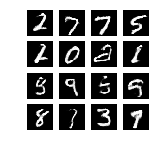

In [9]:
train(models, params, train_steps=5000, batch_size=128, save_interval=100)